### Information about the different models which might be useful when writing the paper
C-RADIOv2 models are available in multiple sizes: Base (90M parameters). Huge (653M parameters). C-RADIOv2 was trained for 1M steps (400k more steps than v1), using inverse frequency sampling for data balancing, and PHI Standardization for teacher distribution balancing. 

Model Architecture
Architecture Type: Neural Network
Network Architecture: Vision Transformer

c-radio-h	ViT-H/16-CPE https://github.com/NVlabs/RADIO

In [1]:
# setup

import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np

MODELS = {
    "clip-vit-base-patch16": "CLIP ViT-B/16",
    "dino_vitb16": "DINO ViT-B/16",
    "dinov2_vitb14": "DINOv2 ViT-B/14",
    "C-RADIOv2-B": "C-RADIOv2 ViT-B/16-CPE",
    "siglip-base-patch16-224": "SigLIP B/16-224", 
    # "tips-b14" : "TIPS ViT-B/14-HR(448)",
}
COLORS = {
    "clip-vit-base-patch16": "#1f77b4",
    "dino_vitb16": "#ff7f0e",
    "dinov2_vitb14": "#2ca02c",
    "C-RADIOv2-B": "#d62728",
    "siglip-base-patch16-224": "#9467bd",
    # "tips-b14": "#8c564b",
}
TRAIN_BINS_DIFFICULTY = {
    "0_30_60_90": "easy",
    "0_45_90": "medium",
    "0_90": "hard",
    "0": "extreme"
}
XTICKS = [0, 15, 30, 45, 60, 75, 90]
CLASS_TO_INDEX = {
    0: 0,
    7: 1,
    8: 2,
    19: 3,
    46: 4,
    57: 5,
    60: 6,
    70: 7,
    99: 8,
    100: 9,
    113: 10,
    125: 11,
    126: 12,
    152: 13,
    166: 14,
    196: 15,
}
CLASS_TO_NAME = {
    0: "background",
    7: "stove",
    8: "sofa",
    19: "microwave",
    46: "bed",
    57: "toy cat",
    60: "toy cow",
    70: "toy dragon",
    99: "coat rack",
    100: "guitar stand",
    113: "ceiling lamp",
    125: "toilet",
    126: "sink",
    152: "strings",
    166: "broccoli",
    196: "durian"
}


# Experiment A

In [2]:
PATH = "results_exp_a_500_sharding_batch4_workers8_dataparallel_memory320000.csv"
DF = pd.read_csv(PATH)

DF

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac10,jac11,jac12,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size
0,12043931,C-RADIOv2-B,0_30_60_90,0,0.623,0.151,0.961,0.598,0.621,0.592,...,0.646,0.851,0.454,0.627,0.715,0.841,768,4,512,16
1,12043931,C-RADIOv2-B,0_30_60_90,15,0.605,0.161,0.960,0.596,0.610,0.545,...,0.631,0.841,0.399,0.643,0.698,0.837,768,4,512,16
2,12043931,C-RADIOv2-B,0_30_60_90,30,0.635,0.147,0.963,0.635,0.644,0.573,...,0.648,0.848,0.459,0.691,0.698,0.843,768,4,512,16
3,12043931,C-RADIOv2-B,0_30_60_90,45,0.620,0.154,0.962,0.640,0.609,0.549,...,0.652,0.832,0.459,0.693,0.692,0.845,768,4,512,16
4,12043931,C-RADIOv2-B,0_30_60_90,60,0.637,0.140,0.964,0.645,0.636,0.542,...,0.651,0.815,0.479,0.696,0.692,0.845,768,4,512,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,12043940,siglip2-base-patch16-512,0,30,0.498,0.182,0.948,0.563,0.558,0.374,...,0.403,0.482,0.206,0.603,0.631,0.793,768,4,512,16
150,12043940,siglip2-base-patch16-512,0,45,0.477,0.185,0.948,0.544,0.528,0.357,...,0.381,0.453,0.189,0.556,0.617,0.790,768,4,512,16
151,12043940,siglip2-base-patch16-512,0,60,0.453,0.188,0.947,0.507,0.523,0.327,...,0.371,0.394,0.165,0.504,0.580,0.779,768,4,512,16
152,12043940,siglip2-base-patch16-512,0,75,0.444,0.189,0.946,0.481,0.522,0.322,...,0.364,0.329,0.192,0.503,0.591,0.773,768,4,512,16


In [3]:
def plot_exp_a(classes: None | list[int], include_bg: bool, extratitle: str):
    """
    Plot experiment A result for specified class.
    Class is either None (all classes) or a list of class numbers
    """
    
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        # remove background class (0) from classes
        classes = [c for c in classes if c != 0]
    
    class_indices = [CLASS_TO_INDEX[c] for c in classes]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=200)
    axes = axes.flatten()

    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        
        train_bins_set = set(map(int, train_bins.split("_")))
                
        for model in MODELS.keys():
            df = DF[DF["model"] == model]
            df = df[df["train_bins"] == train_bins].sort_values("val_bin")

            # only get the jacX values for classes X
            df["jac_mean"] = df[[f"jac{c}" for c in class_indices]].mean(axis=1)
            df["jac_std"] = df[[f"jac{c}" for c in class_indices]].std(axis=1)

            x_values = df["val_bin"]
            y_values = df["jac_mean"].values
            y_error = df["jac_std"].values

            if len(x_values) == 0 or len(y_values) == 0:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # plot the data
            for j, (x_value, y_value) in enumerate(zip(x_values, y_values)):
                # Use asterisk marker if bin is trained on, circle for others
                marker = 'x' if int(x_value) in train_bins_set else 'o'
                ax.scatter(x_value, y_value, label=f"{MODELS[model]}" if j == 1 else "", 
                           color=COLORS[model], marker=marker, s=50, zorder=2)

            # include error bars
            ax.errorbar(x_values, y_values, yerr=y_error, fmt='none', color=COLORS[model], 
                        capsize=5, elinewidth=0)
            
        ax.set_xticks(XTICKS)
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Training bin(s) = {', '.join(train_bins.split('_'))} ({difficulty})")
        # ax.set_title(f"Extreme difficulty, class: ceiling lamp", fontsize=10)
        ax.set_xlabel("Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True)

    axes[0].legend()
    plt.suptitle(f"Experiment A results ({extratitle})", fontsize=14)
    plt.tight_layout()
    plt.show()


## Plots

No data for model siglip-base-patch16-224 with train_bins 0_30_60_90 and classes [7, 8, 19, 46, 57, 60, 70, 99, 100, 113, 125, 126, 152, 166, 196]
No data for model siglip-base-patch16-224 with train_bins 0_45_90 and classes [7, 8, 19, 46, 57, 60, 70, 99, 100, 113, 125, 126, 152, 166, 196]
No data for model siglip-base-patch16-224 with train_bins 0_90 and classes [7, 8, 19, 46, 57, 60, 70, 99, 100, 113, 125, 126, 152, 166, 196]
No data for model dinov2_vitb14 with train_bins 0 and classes [7, 8, 19, 46, 57, 60, 70, 99, 100, 113, 125, 126, 152, 166, 196]
No data for model siglip-base-patch16-224 with train_bins 0 and classes [7, 8, 19, 46, 57, 60, 70, 99, 100, 113, 125, 126, 152, 166, 196]


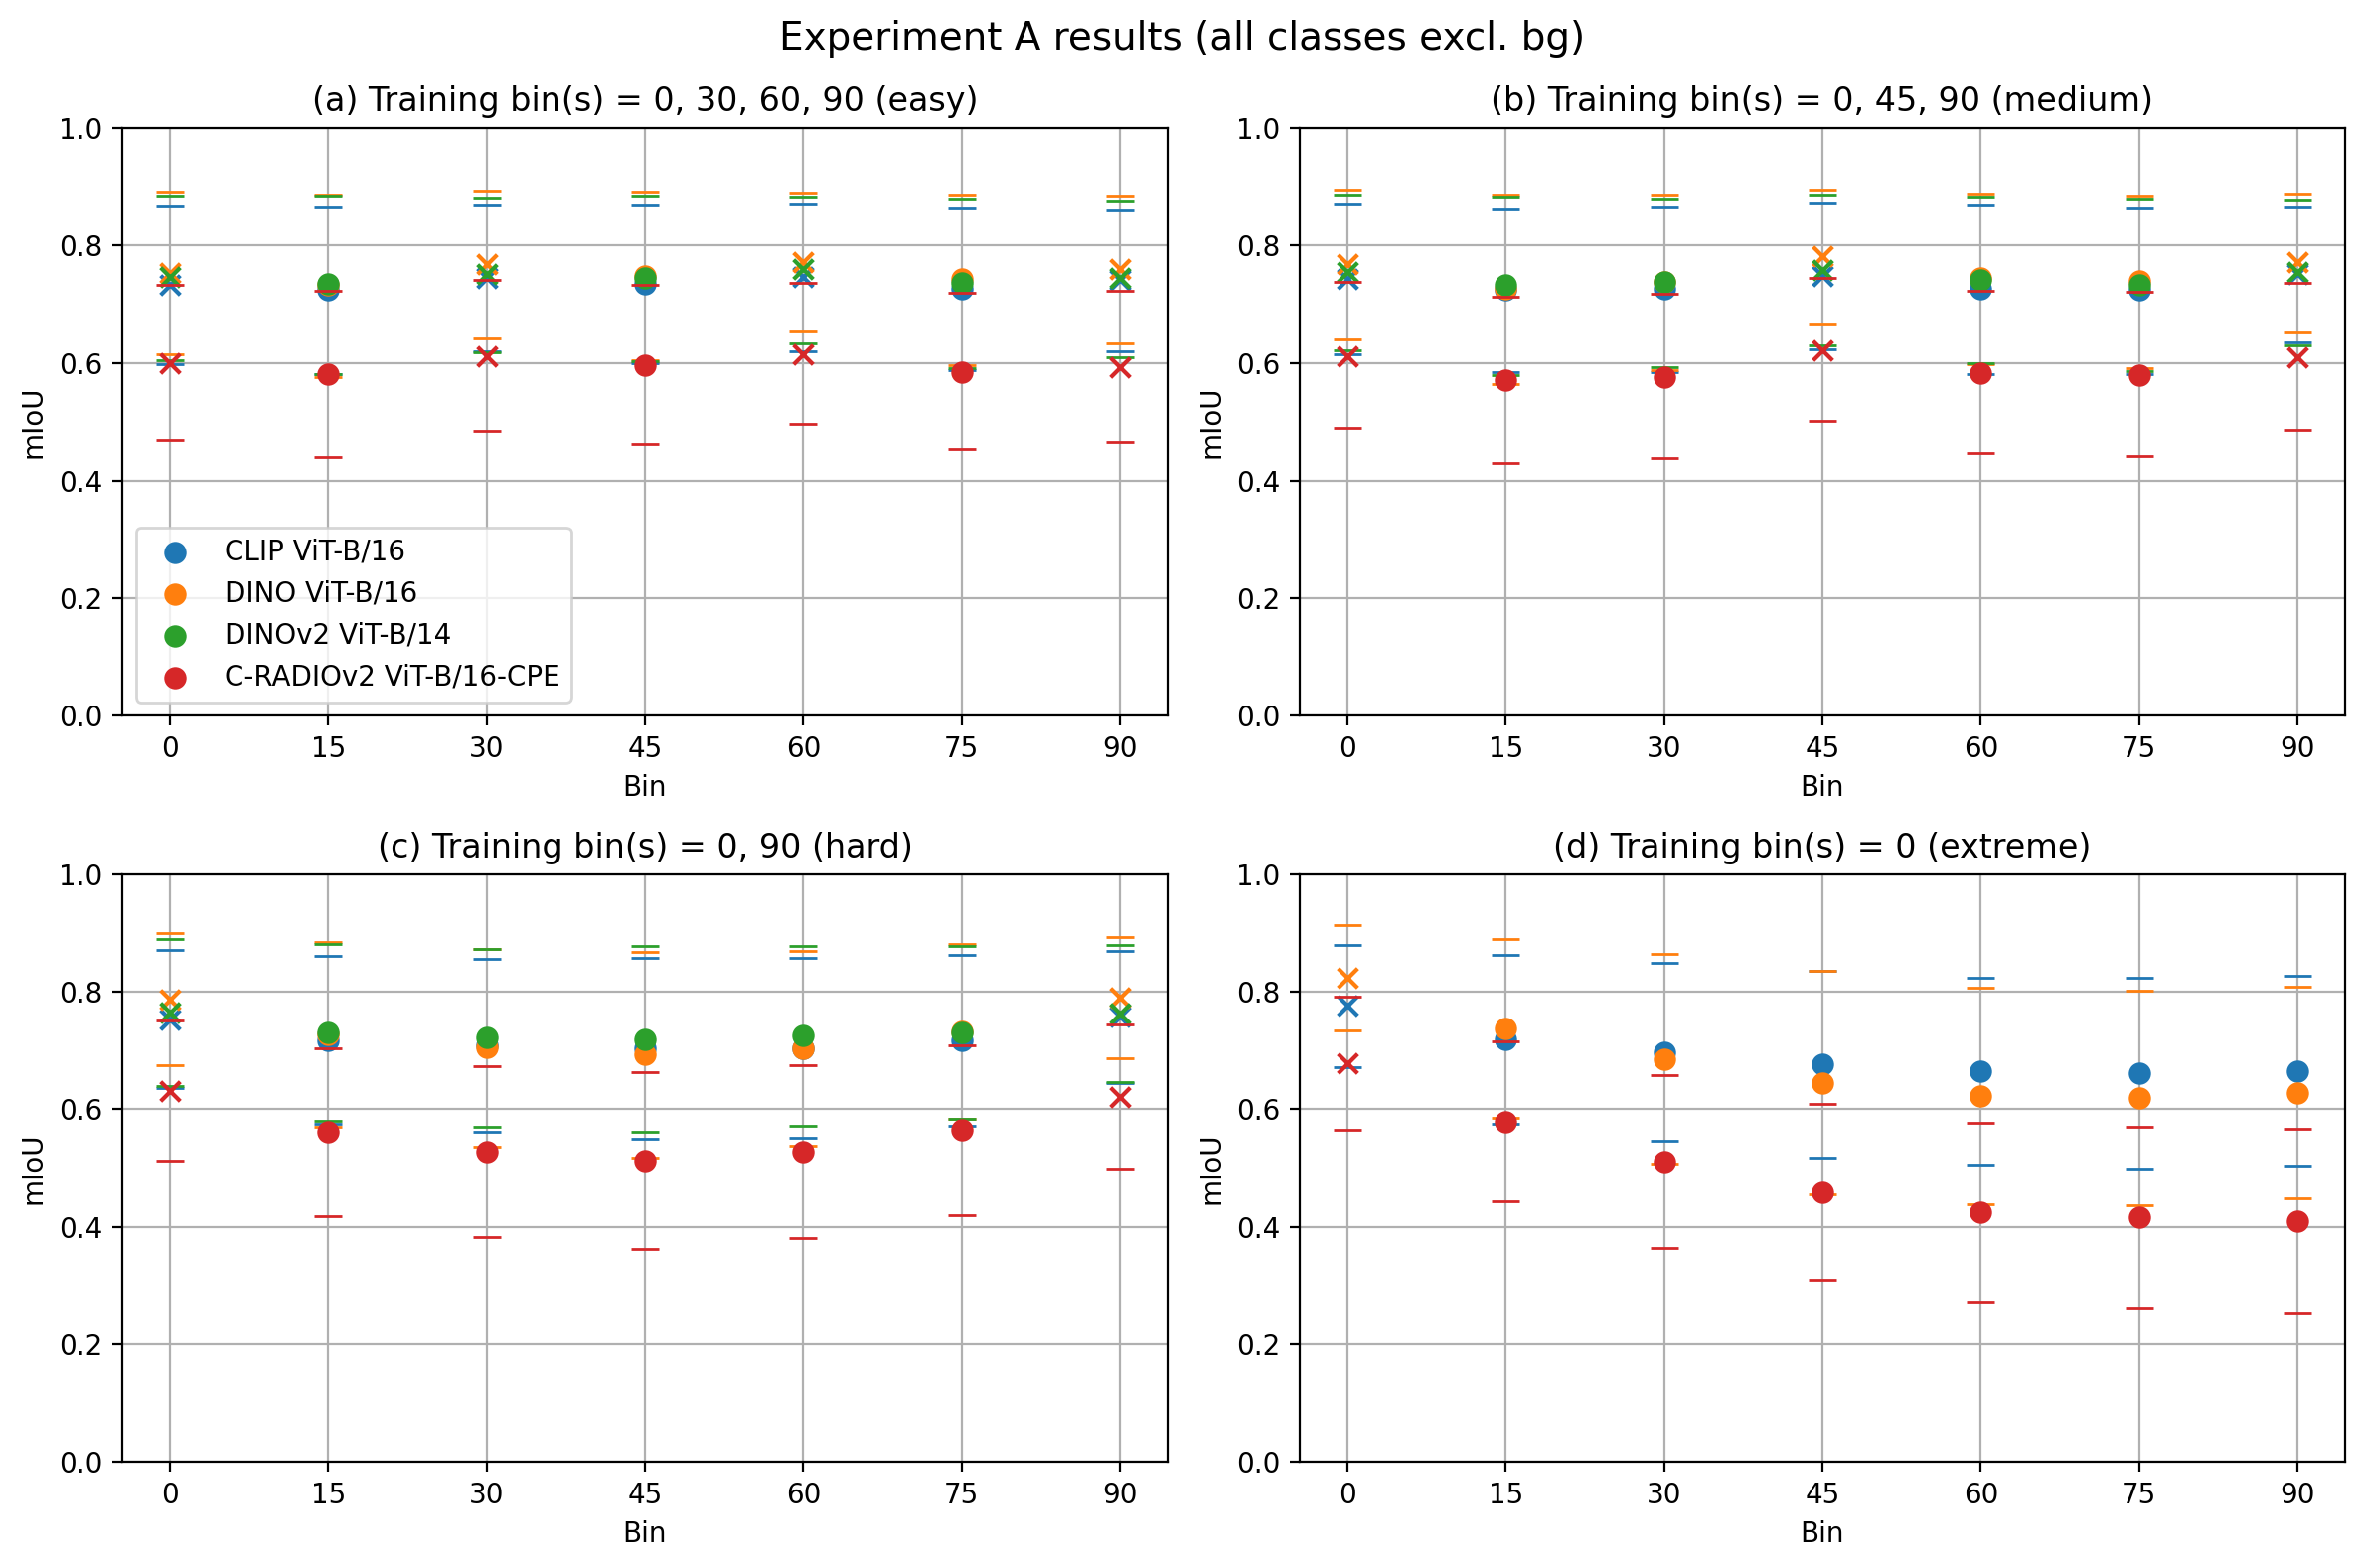

No data for model siglip-base-patch16-224 with train_bins 0_30_60_90 and classes [113]
No data for model siglip-base-patch16-224 with train_bins 0_45_90 and classes [113]
No data for model siglip-base-patch16-224 with train_bins 0_90 and classes [113]
No data for model dinov2_vitb14 with train_bins 0 and classes [113]
No data for model siglip-base-patch16-224 with train_bins 0 and classes [113]


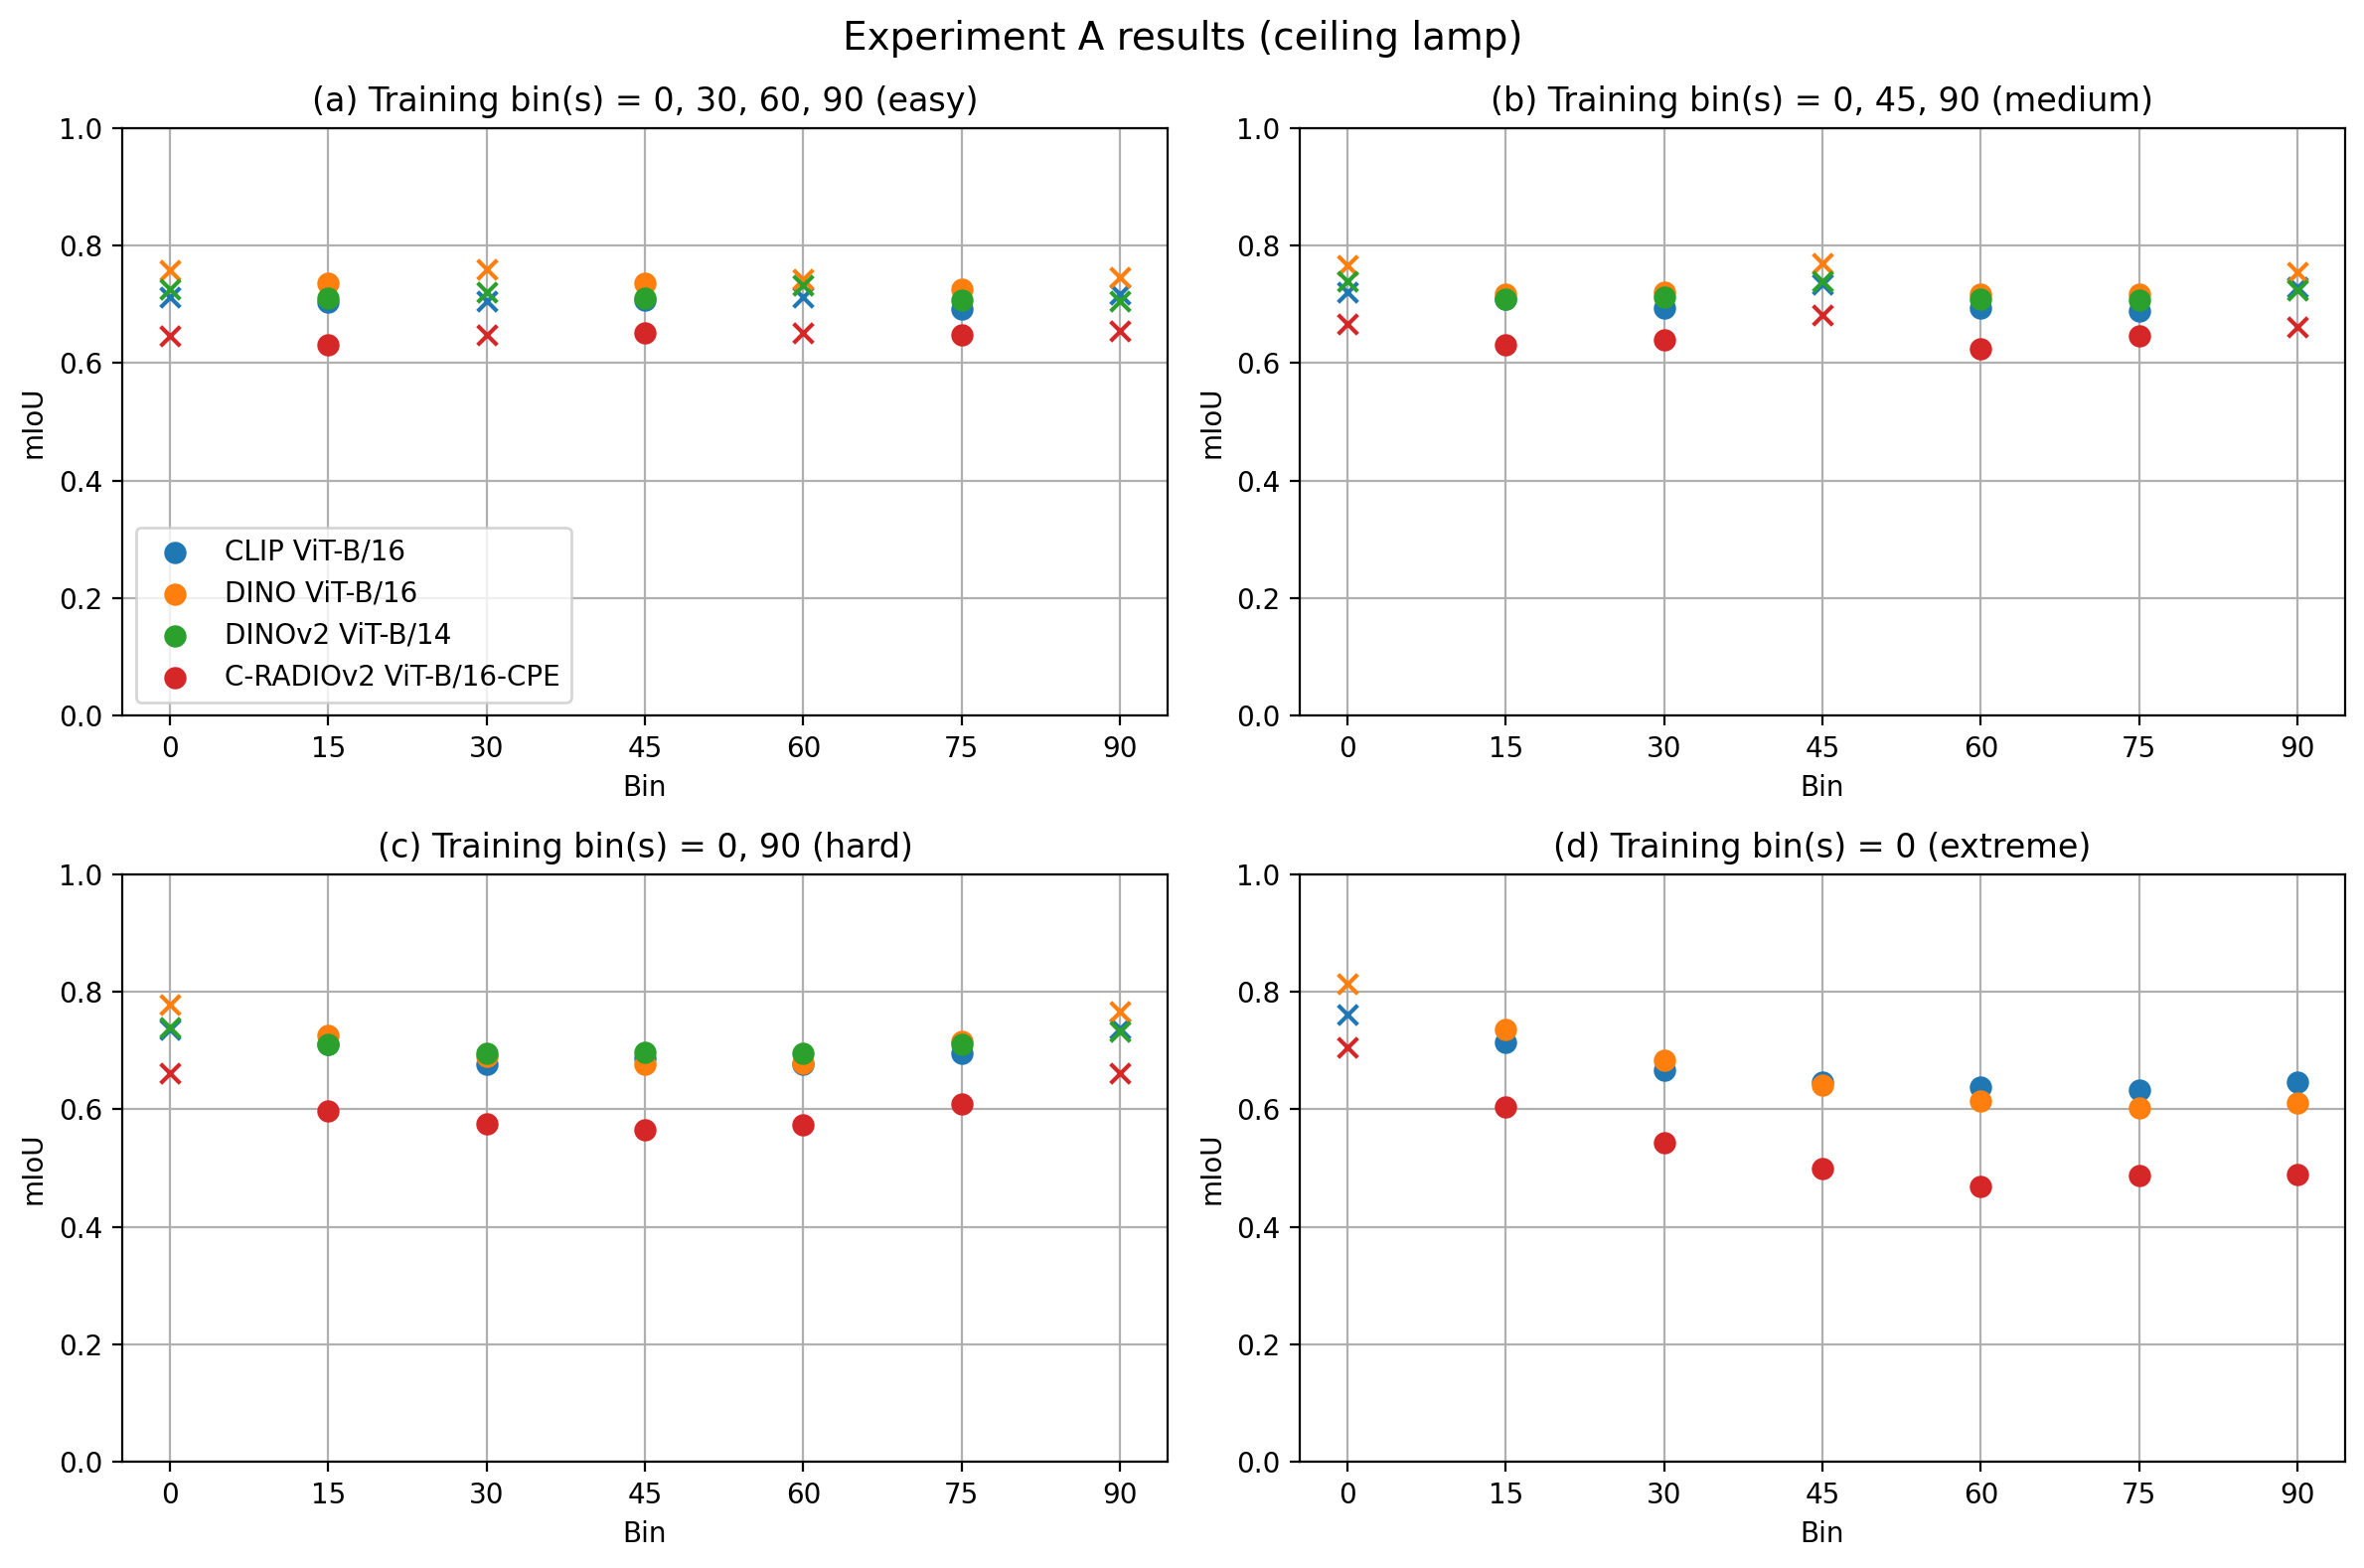

In [4]:
# plot figure with all classes included
plot_exp_a(None, False, extratitle="all classes excl. bg")
# plot_exp_a(None, True, extratitle="all classes incl. bg")

# plot specific classes
plot_exp_a([113], False, extratitle=CLASS_TO_NAME[113])  # ceiling lamp

## Table

In [5]:
df = pd.read_csv(PATH)

# change train_bins to a list of integers
df["train_bins"] = df["train_bins"].apply(lambda x: list(map(int, x.split("_"))))

# if val_bin is in train_bins, set val_in_trained accordingly
df["val_in_trained"] = df.apply(lambda row: row["val_bin"] in row["train_bins"], axis=1)

# set difficulty column
df["difficulty"] = df["train_bins"].apply(lambda x: TRAIN_BINS_DIFFICULTY["_".join(map(str, x))])

# filter only untrained bins
df = df[~df["val_in_trained"]].copy()

df_exp_a = pd.DataFrame(columns=["model", "easy", "medium", "hard", "extreme"])

# for each model and difficulty, calculate the mean and std of jac_mean
for model in MODELS.keys():
    model_df = df[df["model"] == model]
    model_df.loc[:, "jac_mean"] = model_df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
    model_df.loc[:, "jac_std"] = model_df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
    
    # calculate mean and std for each difficulty
    means = model_df.groupby("difficulty")["jac_mean"].mean()
    stds = model_df.groupby("difficulty")["jac_std"].mean()

    # create a row for the model
    row = {
        "model": MODELS[model],
        "easy": f"{means.get('easy', 0):.3f} ± {stds.get('easy', 0):.3f}",
        "medium": f"{means.get('medium', 0):.3f} ± {stds.get('medium', 0):.3f}",
        "hard": f"{means.get('hard', 0):.3f} ± {stds.get('hard', 0):.3f}",
        "extreme": f"{means.get('extreme', 0):.3f} ± {stds.get('extreme', 0):.3f}"
    }
    
    df_exp_a = pd.concat([df_exp_a, pd.DataFrame([row])], ignore_index=True)

df_exp_a

,model,easy,medium,hard,extreme
0,CLIP ViT-B/16,0.729 ± 0.138,0.725 ± 0.141,0.710 ± 0.149,0.681 ± 0.156
1,DINO ViT-B/16,0.741 ± 0.147,0.736 ± 0.150,0.712 ± 0.163,0.656 ± 0.178
2,DINOv2 ViT-B/14,0.738 ± 0.145,0.736 ± 0.146,0.726 ± 0.152,0.000 ± 0.000
3,C-RADIOv2 ViT-B/16-CPE,0.588 ± 0.136,0.579 ± 0.139,0.539 ± 0.146,0.467 ± 0.149
4,SigLIP B/16-224,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000


In [ ]:
# required for to_latex
# !pip install jinja2

In [6]:
# give latex table
latex_table = df_exp_a.to_latex(index=False, escape=False, column_format='lcccc', 
                                  header=["Model", "Easy", "Medium", "Hard", "Extreme"])
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Model & Easy & Medium & Hard & Extreme \\
\midrule
CLIP ViT-B/16 & 0.729 ± 0.138 & 0.725 ± 0.141 & 0.710 ± 0.149 & 0.681 ± 0.156 \\
DINO ViT-B/16 & 0.741 ± 0.147 & 0.736 ± 0.150 & 0.712 ± 0.163 & 0.656 ± 0.178 \\
DINOv2 ViT-B/14 & 0.738 ± 0.145 & 0.736 ± 0.146 & 0.726 ± 0.152 & 0.000 ± 0.000 \\
C-RADIOv2 ViT-B/16-CPE & 0.588 ± 0.136 & 0.579 ± 0.139 & 0.539 ± 0.146 & 0.467 ± 0.149 \\
SigLIP B/16-224 & 0.000 ± 0.000 & 0.000 ± 0.000 & 0.000 ± 0.000 & 0.000 ± 0.000 \\
\bottomrule
\end{tabular}



# Experiment B

In [7]:
PATH = "results_exp_a_500_sharding_batch4_workers8_dataparallel_memory320000.csv"
DF = pd.read_csv(PATH)
DF = DF[DF["train_bins"] == "0"]

DF.head(10)

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac10,jac11,jac12,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size
126,12043931,C-RADIOv2-B,0,0,0.696,0.126,0.967,0.700,0.672,0.714,...,0.705,0.898,0.591,0.718,0.738,0.861,768,4,512,16
127,12043931,C-RADIOv2-B,0,15,0.603,0.157,0.959,0.572,0.601,0.530,...,0.604,0.833,0.414,0.662,0.687,0.841,768,4,512,16
128,12043931,C-RADIOv2-B,0,30,0.539,0.174,0.955,0.476,0.553,0.392,...,0.544,0.758,0.337,0.588,0.644,0.819,768,4,512,16
129,12043931,C-RADIOv2-B,0,45,0.490,0.184,0.952,0.415,0.486,0.302,...,0.500,0.666,0.280,0.525,0.622,0.805,768,4,512,16
130,12043931,C-RADIOv2-B,0,60,0.458,0.191,0.951,0.394,0.480,0.251,...,0.469,0.605,0.245,0.476,0.603,0.789,768,4,512,16
131,12043931,C-RADIOv2-B,0,75,0.450,0.193,0.950,0.396,0.468,0.255,...,0.488,0.626,0.253,0.431,0.583,0.785,768,4,512,16
132,12043931,C-RADIOv2-B,0,90,0.444,0.196,0.949,0.411,0.454,0.267,...,0.489,0.638,0.248,0.418,0.561,0.788,768,4,512,16
133,12043900,clip-vit-base-patch16,0,0,0.788,0.108,0.972,0.849,0.862,0.795,...,0.761,0.855,0.707,0.882,0.869,0.903,768,4,512,16
134,12043900,clip-vit-base-patch16,0,15,0.735,0.148,0.968,0.822,0.814,0.711,...,0.714,0.841,0.547,0.874,0.852,0.893,768,4,512,16
135,12043900,clip-vit-base-patch16,0,30,0.715,0.156,0.968,0.812,0.797,0.666,...,0.666,0.833,0.500,0.870,0.846,0.888,768,4,512,16


In [8]:
def plot_exp_b(normalize=False):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    if normalize:
        plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline performance")
        plot_title = "Experiment B results (normalized to 0-bin performance)"
        y_label = "Normalized mIoU"
    else:
        plot_title = "Experiment B results"
        y_label = "mIoU"

    for model in MODELS.keys():
        df = DF[DF["model"] == model].copy()
        df["jac_mean"] = df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
        df["jac_std"] = df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

        if not normalize:
            # plot the 0-bin performance
            df0 = df[df["val_bin"] == 0]
            x_values = df0["val_bin"]
            y_values = df0["jac_mean"]
            plt.scatter(x_values, y_values, color=COLORS[model], marker="x", s=100, zorder=5)

        # plot the other validation bins [15, ..., 90]
        if normalize:
            # get bin=0 performance
            df0 = df[df["val_bin"] == 0]
            model_0_score = df0["jac_mean"].values[0]

            df1590 = df[df["val_bin"] != 0].copy()
            df1590["jac_norm"] = df1590["jac_mean"] / model_0_score
            x_values = df1590["val_bin"]
            y_values = df1590["jac_norm"]
        else:
            df1590 = df[df["val_bin"] != 0]
            x_values = df1590["val_bin"]
            y_values = df1590["jac_mean"].values

        plt.plot(x_values, y_values, label=MODELS[model], color=COLORS[model])

    plt.xlabel("Bin")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.xticks(XTICKS)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()


## Plots

IndexError: index 0 is out of bounds for axis 0 with size 0

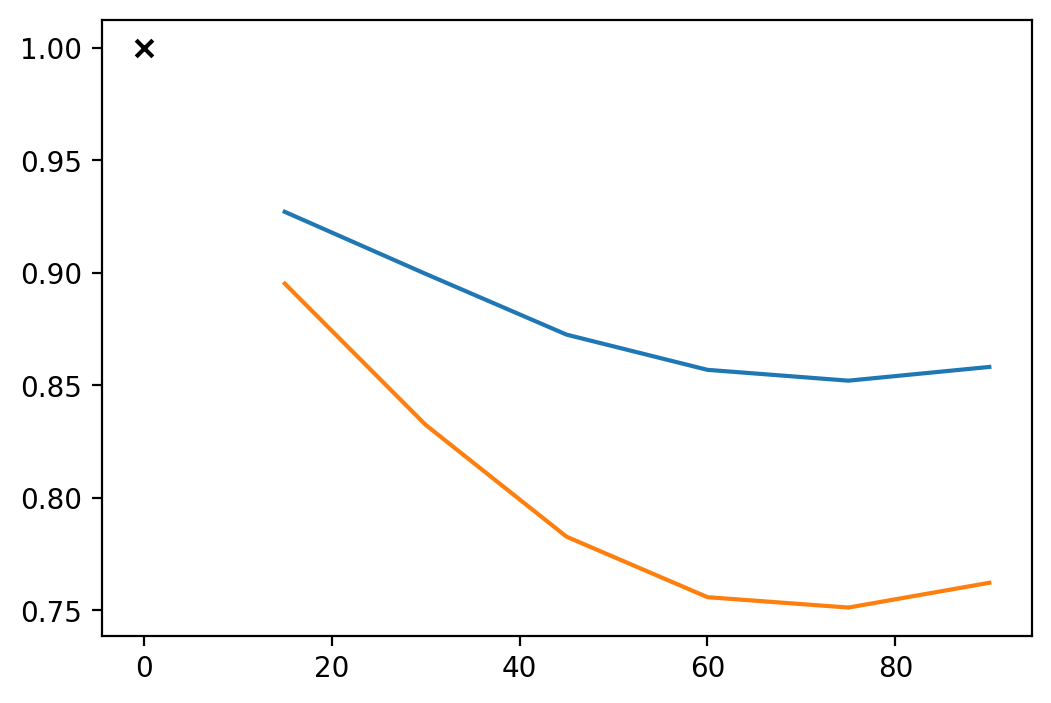

In [9]:
plot_exp_b(normalize=True)
plot_exp_b(normalize=False)

## Table

In [10]:
DF = pd.read_csv(PATH)
DF.loc[:, "jac_mean"] = DF[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
DF.loc[:, "jac_std"] = DF[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
DF = DF[DF["train_bins"] == "0"]  # extreme difficulty

# df_exp_b = pd.DataFrame(columns=["model", "breaking_point"])

test_df = None

threshold = 0.05

for model in MODELS.keys():
    df = DF[DF["model"] == model].copy()

    # get bin=0 performance
    df0 = df[df["val_bin"] == 0]
    model_0_score = df0["jac_mean"].values[0]

    # df = df[df["val_bin"] != 0].copy()
    df["jac_norm"] = df["jac_mean"] / model_0_score

    # jac_mean_prev is jac_mean but shifted down by one row
    df["jac_norm_prev"] = df["jac_norm"].shift(1)
    # delta is difference between jac norm and shifted jac norm
    df["delta"] = df["jac_norm"] - df["jac_norm_prev"]
    df = df[df["val_bin"] != 0]

    # concat
    if test_df is None:
        test_df = df.copy()
    else:
        test_df = pd.concat([test_df, df], ignore_index=True)

    # row = {
    #     "model": MODELS[model],
    #     "breaking_point": breaking_point
    # }
    # df_exp_b = pd.concat([df_exp_b, pd.DataFrame([row])], ignore_index=True)

test_df

# check the last column called delta for source on these numbers, compare with threshold
# clip: no bp, dino: 30, dinov2: no bp, C-RADIOv2: 30, siglip: 30

IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:
# give latex table
latex_table_exp_b = df_exp_b.to_latex(index=False, escape=False, column_format='lc', 
                                        header=["Model", "Breaking point (bin)"])
print(latex_table_exp_b)

NameError: name 'df_exp_b' is not defined